In [1]:
%matplotlib inline
import sys
import matplotlib
import matplotlib.pyplot as plt
import glob, os
import numpy as np
from numpy.polynomial import polynomial as P
import re, csv
import pandas as pd
from math import sqrt
import seaborn as sns
from numpy.polynomial import polynomial as P
from scipy import stats
from scipy.stats import linregress
sns.set_style("whitegrid")
import itertools
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Load Voimooo python wrapper
sys.path.insert(0, os.path.abspath('../../pyvoimooo/'))
import pyvoimooo as vmo
vmo.__version__

INFO: Wav write/read: Using libsndfile in Voimooo


'0.17.6'

In [3]:
sys.path.insert(0, os.path.abspath('../../cleese'))
import cleese 

# Analyse de données revcor SMILE - Tours data
Données patients 2020 recueillies par Stéphanie Miny (CNAM)\
Données contrôles 2017 recueillies par Emmanuel Ponsot, Pablo Arias & JJ Aucouturier (CNRS)\
Données Tours 2021 recueillies par Marie Gomot et Annabelle Merchie (INSERM) 

## Data organization

In [4]:
datasets = [{'type':'patients','exp':'miny', 'base_sound':'M_n_cut.wav'},
            {'type':'controls','exp':'ponsot','base_sound':'M_n_cut.wav'},
            {'type':'tours_1_adultes','exp':'gomot','base_sound':'neutre_1_flat.wav'},
            {'type':'tours_2_adultes','exp':'merchie','base_sound':'neutre_2_flat.wav'},
            {'type':'tours_2_adultes_TSA','exp':'merchie','base_sound':'neutre_2_flat.wav'},
            {'type':'tours_2_enfants','exp':'merchie','base_sound':'neutre_2_flat.wav'},
           ]

data_df = pd.DataFrame()

for dataset in datasets: 
    result_dir = 'data/'+dataset['type']+'/'
    result_files = glob.glob(result_dir+"results_subj*.csv")
    results = pd.DataFrame()
    for result_file in result_files: 
        #print(result_file)
        participant_results = pd.read_csv(result_file, sep = ',', decimal='.', header='infer')
        results = results.append(participant_results, ignore_index=True)
    results['type'] = dataset['type']
    results['experimentateur'] = dataset['exp']
    results['base_sound'] = dataset['base_sound']
    data_df = data_df.append(results, ignore_index=True)

In [6]:
# save Tours data (remove practice trials, drop session as Tours has only one)
data_df[(data_df.block != 0)&(data_df.type=='tours_2_adultes')].drop(columns=['session']).to_csv('data/data_tours_2.csv')
data_df[(data_df.block != 0)&(data_df.type=='tours_2_adultes_TSA')].drop(columns=['session']).to_csv('data/data_tours_2_TSA.csv')
data_df[(data_df.block != 0)&(data_df.type=='tours_1_adultes')].drop(columns=['session']).to_csv('data/data_tours_1.csv')

In [7]:
# save Controls data (remove practice trials)
data_df[(data_df.block != 0)&(data_df.type=='controls')].to_csv('data/data_controls.csv')

## Compute 1st-order kernels

In [8]:
def compute_kernels(data_df): 
    
    # first-order kernel computed for each subject as the
    # mean(filter gains of voices classified as smiling) - (mean filter gains of voices classified as non-smiling)

    filter_mean_gain = data_df.groupby(['subj','filter_freq','response','base_sound'])['filter_gain'].mean().reset_index()
    positives = filter_mean_gain.loc[filter_mean_gain['response'] == 1].reset_index()
    negatives = filter_mean_gain.loc[filter_mean_gain['response'] == 0].reset_index()
    kernels = pd.merge(positives, negatives, on=['subj','base_sound','filter_freq'])
    kernels['kernel_gain'] = kernels['filter_gain_x'] - kernels['filter_gain_y']

    
    # Kernels are then normalized for each participant by dividing them 
    # by the square root of the sum of their squared values.
    kernels['square_gain'] = kernels['kernel_gain']**2
    for_norm = kernels.groupby(['subj'])['square_gain'].mean().reset_index()
    kernels = pd.merge(kernels, for_norm, on=['subj'])
    kernels['norm_gain'] = kernels['kernel_gain']/np.sqrt(kernels['square_gain_y'])

    kernels.drop(columns=['index_x','response_x','filter_gain_x',
                      'index_y','response_y','filter_gain_y',
                      'square_gain_x', 'square_gain_y'], inplace=True)
    return kernels

In [10]:
data_df = pd.read_csv('data/data_tours_2.csv', index_col=0)
kernels = compute_kernels(data_df)

0 Hz: t(14) = 0.92, p = 0.3739
104 Hz: t(14) = 2.69, p = 0.0175 (*) 
224 Hz: t(14) = -3.21, p = 0.0063 (*) 
362 Hz: t(14) = -3.26, p = 0.0057 (*) 
521 Hz: t(14) = 1.77, p = 0.0987
704 Hz: t(14) = 2.42, p = 0.0297 (*) 
914 Hz: t(14) = -0.54, p = 0.5961
1155 Hz: t(14) = -1.06, p = 0.3087
1432 Hz: t(14) = -3.58, p = 0.0030 (*) 
1751 Hz: t(14) = -1.71, p = 0.1088
2117 Hz: t(14) = 2.83, p = 0.0133 (*) 
2538 Hz: t(14) = 5.06, p = 0.0002 (*) 
3022 Hz: t(14) = 1.68, p = 0.1160
3578 Hz: t(14) = -2.08, p = 0.0559
4217 Hz: t(14) = -1.00, p = 0.3349
4952 Hz: t(14) = -0.80, p = 0.4349
5796 Hz: t(14) = 1.54, p = 0.1459
6767 Hz: t(14) = -0.55, p = 0.5941
7883 Hz: t(14) = 1.78, p = 0.0971
9165 Hz: t(14) = -1.06, p = 0.3055


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


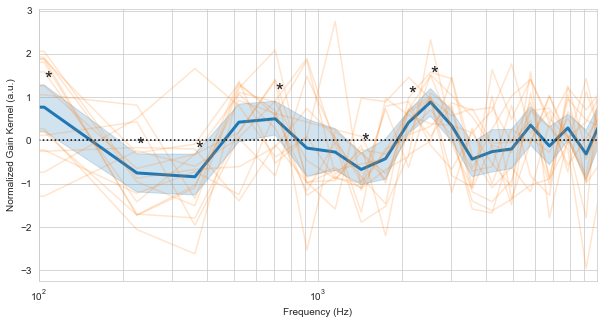

In [11]:
fig,ax = plt.subplots(figsize=(10,5))

crop_x = 10000

# display kernels 
sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=kernels,
             ci=95, 
             ax=ax, lw=3)
sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=kernels,
             units='subj',
             estimator=None,
             ci=95, 
             ax=ax, 
             alpha=0.2)
_=ax.set_xlabel("Frequency (Hz)")
#ax.legend(loc='upper left')
_=ax.set_ylabel("Normalized Gain Kernel (a.u.)")
_=ax.plot([0,crop_x],[0,0],color='k',linestyle = ':')
#ax.set_title(title)
_=plt.xscale('log')
_=ticks=np.concatenate((np.arange(100,1000,100),np.arange(1000,crop_x,1000)))
_=plt.xticks(ticks)
_=ax.set_xlim([100,crop_x]);


# statistics: one-sample t-test to 0 at each filter frequency
import pingouin as pg
freqs = list(kernels[kernels.filter_freq<10000].filter_freq.unique())
alpha=0.05 
font_size = 20
vskip = 0.5

for freq in freqs: 
    
    gains = list(kernels[kernels.filter_freq==freq].norm_gain)
    stats = pg.ttest(gains,0)
    print("%d Hz: t(%d) = %.2f, p = %6.4f" %(freq,stats['dof'],stats['T'],stats['p-val']), end='')
    if (stats.loc['T-test','p-val']<alpha):
        print(' (*) ')
        _=plt.text(x=freq,
                 y=kernels[kernels.filter_freq==freq].norm_gain.mean()+vskip,
                 s='*', size=font_size)        
        
    else:
        print()

## Synthesize sound effect of kernel

In [16]:
def apply_kernel(wave_in, sr, filter_freq, filter_gain, gain):
        
    # create bpf
    num_channel = len(filter_freq)
    bpf = np.zeros((1,2+2*num_channel))
    bpf_val = []
    for f,g in zip(filter_freq,filter_gain): 
        bpf_val += f, np.exp(gain*g)
    #bpf_val += sr/2, 1
    bpf_val = np.array([0, num_channel] + bpf_val)
    bpf[0,:] = bpf_val
    
    # process with cleese
    config_file = "random_eq_profile.py"
    wav_out,bpf_out = cleese.process(soundData=wave_in, configFile=config_file, sr=sr, BPF=bpf)
    
    return wav_out, bpf_out

In [17]:
from IPython.display import Markdown, display, Audio

input_file = 'sounds/base_sounds/'+kernels.base_sound.unique()[0]
wave_in,sr =  vmo.readwav(input_file)

GAIN = 2

print("son de base")
Audio(data=wave_in, rate=sr)

print("souriant groupe")
kernel_tours = kernels.groupby(['filter_freq']).norm_gain.mean().reset_index()
wave_out, bpf_out = apply_kernel(wave_in, sr, 
                                 kernel_tours.filter_freq, 
                                 kernel_tours.norm_gain, 
                                 GAIN)
Audio(data=wave_out, rate=sr)
# save audio
#output_file = os.path.splitext(input_file)[0]+'_smile_tours.wav'
#vmo.writewav(output_file, sr, wave_out)
# save config (warning bpf_out are np.exp(gain), so np.log them back to db)
#config_file = os.path.splitext(output_file)[0]+'.txt'
#info = [[x,y] for x,y in zip(bpf_out[0][2::2],np.log(bpf_out[0][3::2]))]
#with open(config_file,'w+',newline='') as file:
#    writer = csv.writer(file);
#    for row in info:
#        _=writer.writerow(row)

print("anti-souriant groupe")
wave_out, bpf_out = apply_kernel(wave_in, sr, 
                                 kernel_tours.filter_freq,
                                 -kernel_tours.norm_gain, 
                                 GAIN)
Audio(data=wave_out, rate=sr)
# save audio
#output_file = os.path.splitext(input_file)[0]+'_antismile_tours.wav'
#vmo.writewav(output_file, sr, wave_out)
# save config (warning bpf_out are np.exp(gain), so np.log them back to db)
#config_file = os.path.splitext(output_file)[0]+'.txt'
#info = [[x,y] for x,y in zip(bpf_out[0][2::2],np.log(bpf_out[0][3::2]))]
#with open(config_file,'w+',newline='') as file:
#    writer = csv.writer(file);
#    for row in info:
#        _=writer.writerow(row)
        

son de base


souriant groupe
eq variation 1/1


anti-souriant groupe
eq variation 1/1


## Visualize effect on spectral envelopes (requires voimoo)

We use the vmo smile transformation to extract spectral envelopes

In [143]:
def spectral_env(wave_in, sr): 
    # extract mean spectral envelope from wave_file using the vmo smile transform
    syn, tts, f0s, envs_ori, envs_new  = vmo.smile(wave_in,sr, alpha=1.)
    env = np.mean(envs_ori,0)
    f = np.linspace(0,sr/2,len(env))
    return f,env 

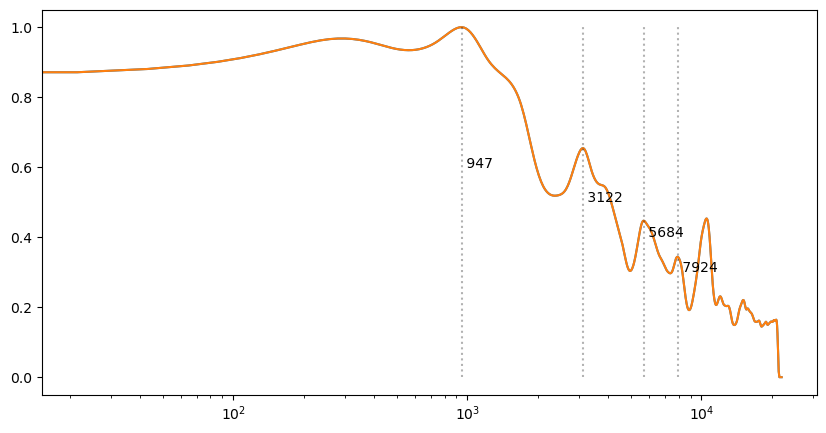

In [144]:
# extract base envelope
input_file = 'sounds/base_sounds/'+kernels.base_sound.unique()[0]
wave_in,sr =  vmo.readwav(input_file)
base_f, base_env = spectral_env(wave_in,sr)
# normalize amplitude & log
base_env = np.log(base_env)
base_env = (base_env - np.min(base_env))
base_env = (base_env / np.max(base_env))
fig,ax = plt.subplots(figsize=(10,5))
_=plt.plot(base_f, base_env);
plt.xscale('log');

# extract formants
from scipy.signal import argrelextrema
peaks = base_f[argrelextrema(base_env,
                             np.greater)]
base_formants = peaks[(500<peaks) & (peaks<10000)]
base_formants = base_formants[[0,1,2,3]]

_=plt.plot(base_f, base_env);
plt.xscale('log')
for id,formant in enumerate(base_formants):
    _=plt.plot([formant,formant],[0, 1], 'k:', alpha=0.3);
    _=plt.text(x=formant,y=0.6-id*0.1,
               s=' %d'%formant,
               size=10,
               ha='left')
    #print(formant)

In [145]:
def display_kernel_enveloppe(kernels_df,title, ax1):
    
    crop_x = 10000 # Hz
    enveloppe_gain = 5
    
    # display kernels (patients and controls)
    sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=kernels,
             ci=95, ax=ax1)
    ax1.set_xlabel("Frequency (Hz)")
    #ax1.legend(loc='upper left')
    ax1.set_ylabel("Normalized Gain Kernel (a.u.)")
    ax1.plot([0,crop_x],[0,0],color='k',linestyle = ':')
    ax1.set_title(title)
    plt.xscale('log')
    ax1.set_xlim([100,crop_x])

    # display base enveloppe
    plt.plot(base_f, enveloppe_gain**base_env,'k')
    
    # display base formants 
    for index, formant in enumerate(base_formants):
        plt.plot([formant,formant],[0, enveloppe_gain-1], 'k:')
        plt.text(formant, enveloppe_gain-0.9, 'F'+str(index+1), horizontalalignment = 'center')

    # display enveloppe of sound filtered by kernel
    group_kernel = kernels.groupby('filter_freq')['norm_gain'].mean().reset_index()
    filter_freq = list(group_kernel.filter_freq)
    filter_gain = list(group_kernel.norm_gain)
        
    wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                 sr=sr,
                                 filter_freq=filter_freq,
                                 filter_gain=filter_gain, 
                                 gain=1.5)
    f_out,env_out = spectral_env(wave_out,sr)
    env_out = np.log(env_out)
    env_out = (env_out - np.min(env_out))
    env_out = (env_out / np.max(env_out))
    plt.plot(f_out, enveloppe_gain**env_out,color='b');



eq variation 1/1


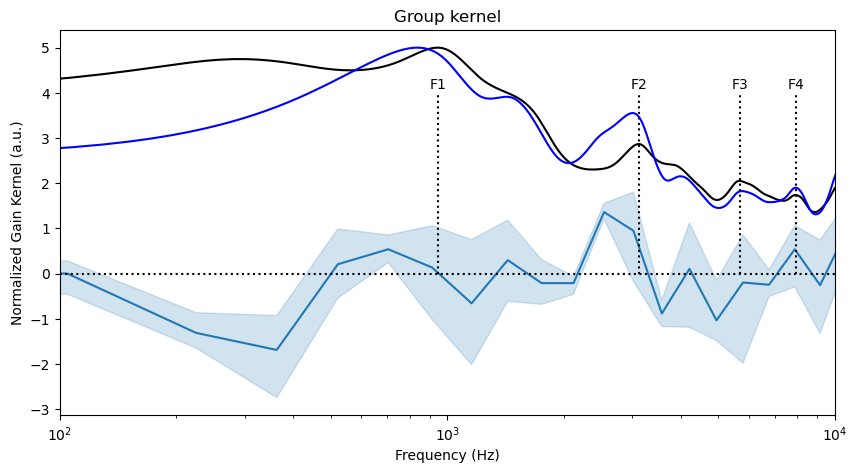

In [146]:
fig,ax = plt.subplots(figsize=(10,5))
plt.style.use('default')
display_kernel_enveloppe(kernels,'Group kernel',ax)

In [82]:
def visualize_kernel(wave_in, sr, filter_freq, filter_gain, ax1, gain_range):
    
    # apply kernel with several gains, and store in dataframe
    #gain_range = np.arange(2,-0.5,-0.1)
    freqs = []
    amps = []
    gains = []
    for gain in gain_range:
        wave_out, bpf_out = apply_kernel(wave_in = wave_in,
                                         sr=sr,
                                         filter_freq=filter_freq, 
                                         filter_gain=filter_gain,
                                         gain=gain)
    
        f_out,env_out = spectral_env(wave_out,sr)
        freqs+=list(f_out)
        amps+=[np.log(g) for g in list(env_out)]
        gains+=len(f_out)*[gain]
        
    data = pd.DataFrame.from_dict({'f':freqs, 'amp':amps, 'gain':gains})
    
    # plot
    sns.lineplot(data=data, 
            x='f',
            y='amp',
            hue='Gain ' + data['gain'].astype(str), 
            palette="RdBu", 
            ax=ax1)
    _=plt.xscale('log')
    #_=plt.xlim([400, 2000])
    #_=plt.ylim([-10,-2])
    _=plt.legend('',frameon=False)

    # plot original env
    f_in, env_in = spectral_env(wave_in,sr)
    _=plt.plot(f_in,[np.log(g) for g in list(env_in)], 'k')

eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1
eq variation 1/1


Text(0.5, 0, 'Freq (Hz)')

Text(0, 0.5, 'Power (a.u)')

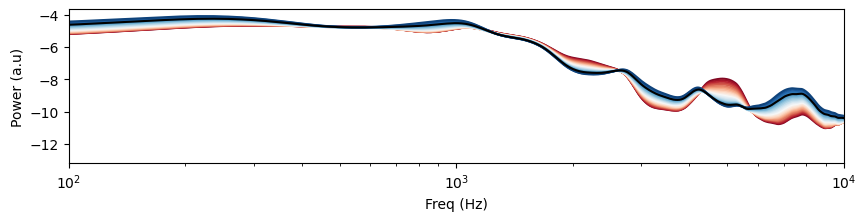

In [83]:
# figure JASA
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1,1,1)
control_kernels = kernels.groupby('filter_freq')['norm_gain'].mean().reset_index()
visualize_kernel(wave_in, sr, 
                 list(control_kernels.filter_freq), 
                 list(control_kernels.norm_gain), 
                 ax, np.arange(2,-0.5,-0.1))
_=plt.xlim([100, 10000])
plt.xlabel('Freq (Hz)')
plt.ylabel('Power (a.u)')

## Compare filter locations

(0.0, 1.5)

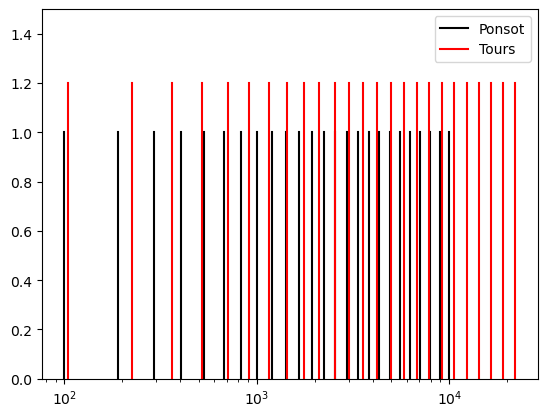

In [46]:
from matplotlib.lines import Line2D
data_df = pd.read_csv('data/data_controls.csv', index_col=0)
for freq in data_df.filter_freq.unique(): 
    _=plt.plot([freq,freq],[0,1],'k')
data_df = pd.read_csv('data/data_tours.csv', index_col=0)
for freq in data_df.filter_freq.unique(): 
    _=plt.plot([freq,freq],[0,1.2],'r')
_=plt.xscale('log') 
ponsot = Line2D([0], [0], label='Ponsot', color='k')
tours = Line2D([0], [0], label='Tours', color='r')
plt.legend(handles=[ponsot,tours])
plt.ylim([0,1.5])
plt.savefig('./pics/compare_filters.jpg', format='jpg', dpi=600, transparent=True)

## Analyse convergence

Compute kernel after all t from 1:n_trials, and correlate with final kernel

In [47]:
data_df = pd.read_csv('data/data_controls.csv', index_col=0)

In [48]:
# compute kernels for all expanding lists of trials

filter_mean_gain = data_df.sort_values('trial').groupby(['subj','filter_freq','response','base_sound']).expanding().agg({'filter_gain':'mean',
                                                                                                     'trial':'count'}).reset_index()
positives = filter_mean_gain.loc[filter_mean_gain['response'] == 1].reset_index()
negatives = filter_mean_gain.loc[filter_mean_gain['response'] == 0].reset_index()
cumulated_kernels = pd.merge(positives, negatives, on=['subj','base_sound','filter_freq','trial'])
cumulated_kernels['kernel_gain'] = cumulated_kernels['filter_gain_x'] - cumulated_kernels['filter_gain_y']

# Kernels are then normalized for each participant by dividing them 
# by the square root of the sum of their squared values.
cumulated_kernels['square_gain'] = cumulated_kernels['kernel_gain']**2
for_norm = cumulated_kernels.groupby(['subj','trial'])['square_gain'].mean().reset_index()
cumulated_kernels = pd.merge(cumulated_kernels, for_norm, on=['subj','trial'])
cumulated_kernels['norm_gain'] = cumulated_kernels['kernel_gain']/np.sqrt(cumulated_kernels['square_gain_y'])

cumulated_kernels.drop(columns=['index_x','response_x','filter_gain_x','level_4_x',
                      'index_y','response_y','filter_gain_y','level_4_y',
                      'square_gain_x', 'square_gain_y'], inplace=True)

Sanity check

     subj  filter_freq  norm_gain
0       1        100.0        601
1       1        191.0        601
2       1        293.0        601
3       1        406.0        601
4       1        533.0        601
..    ...          ...        ...
245    10       6245.0        601
246    10       7037.0        601
247    10       7920.0        601
248    10       8904.0        601
249    10      10000.0        601

[250 rows x 3 columns]


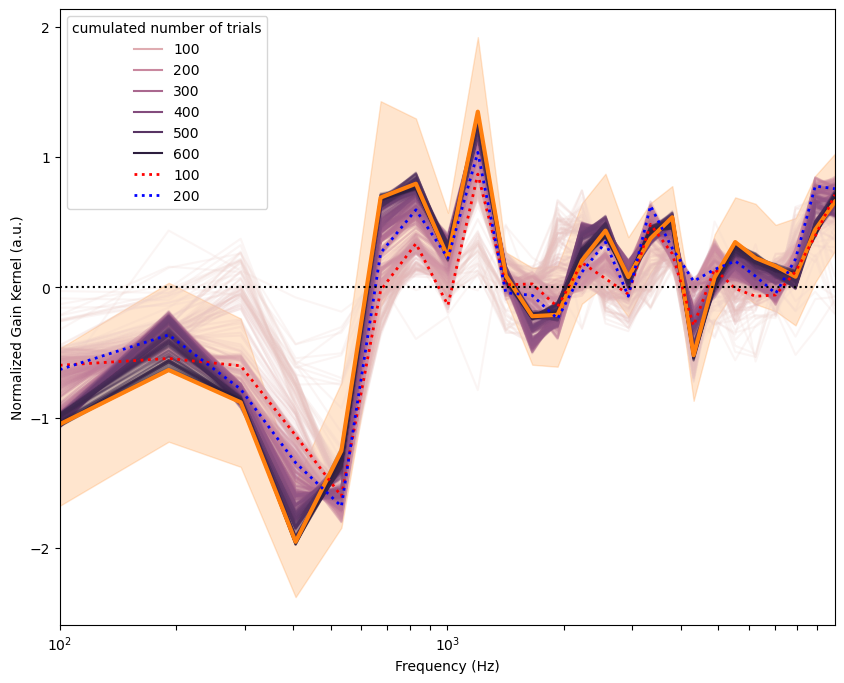

In [49]:
# each subj has 300 (n_trials) gain values for each kernel freq
print(cumulated_kernels.groupby(['subj','filter_freq']).norm_gain.count().reset_index())

max_trial = cumulated_kernels.trial.max()
# and n°300 is the same as the individual mean kernel
fig,ax = plt.subplots(figsize=(10,8))
crop_x = 10000
sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=cumulated_kernels.groupby(['trial','filter_freq']).norm_gain.mean().reset_index(),
             units='trial',hue='trial',
             estimator=None,
             ci=95, 
             ax=ax, 
             alpha=0.2)
sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=cumulated_kernels[cumulated_kernels.trial==max_trial],
             ci=95, 
             ax=ax, lw=3)

sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=cumulated_kernels[cumulated_kernels.trial==100],
             ci=None, 
             ax=ax, lw=2, color='red', linestyle=':', label="100")

sns.lineplot(x="filter_freq",
             y="norm_gain",
             data=cumulated_kernels[cumulated_kernels.trial==200],
             ci=None, 
             ax=ax, lw=2, color='blue', linestyle=':', label='200')

_=ax.set_xlabel("Frequency (Hz)")
_=ax.set_ylabel("Normalized Gain Kernel (a.u.)")
_=ax.plot([0,crop_x],[0,0],color='k',linestyle = ':')
_=plt.xscale('log')
_=ticks=np.concatenate((np.arange(100,1000,100),np.arange(1000,crop_x,1000)))
_=plt.xticks(ticks)
_=ax.set_xlim([100,crop_x]);
plt.legend(title='cumulated number of trials', fancybox=True, loc=2).set_zorder(-1000)
plt.savefig('./pics/convergence_kernel_tours.jpg', format='jpg', dpi=600, transparent=True)

In [50]:
# compute correlation with mean individual (n=300) kernel

max_trial = cumulated_kernels.trial.max()

final_kernels = cumulated_kernels.loc[cumulated_kernels.trial==max_trial,
                                      ['subj','filter_freq','norm_gain']].set_index(['subj','filter_freq'])

matched_kernels = cumulated_kernels.join(final_kernels, 
                                         on=['subj','filter_freq'], rsuffix='_final')
# correlation 
correlation = matched_kernels.sort_values(['subj','filter_freq']).groupby(['subj','trial']).apply(lambda x: 
                                          pg.corr(x['norm_gain'],
                                                  x['norm_gain_final'],
                                                  method='pearson').r).reset_index()



c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\pingouin\effsize.py:135: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\pingouin\power.py:899: RuntimeWarning: divide by zero encountered in arctanh
  zr = np.arctanh(r) + r / (2 * (n - 1))


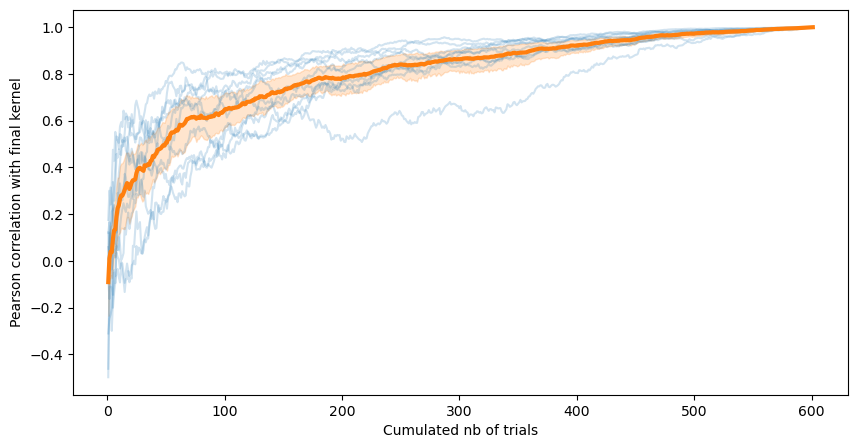

In [51]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x="trial",
             y="pearson",
             data=correlation,
             units='subj',
             estimator=None,
             ci=95, 
             ax=ax, 
             alpha=0.2)
sns.lineplot(x="trial",
             y="pearson",
             data=correlation,
             ci=95, 
             ax=ax, lw=3)
_=ax.set_xlabel("Cumulated nb of trials")
_=ax.set_ylabel("Pearson correlation with final kernel")

plt.savefig('./pics/convergence_tours.jpg', format='jpg', dpi=600, transparent=True)

## Synthesize dynamic stimuli

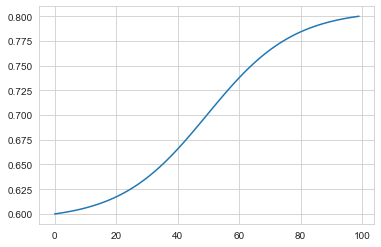

In [19]:
def sigmoid(x_min=0, x_max=100, y_min=-1, y_max=1, n_points=100, slope = 7): 
    
    # sample n_points between x_min and x_max
    x = np.linspace(start=x_min,
                    stop=x_max,
                    num=n_points)
    
    # center sigmoid at midrange
    center= np.median(x)
    
    # scale slope to range 
    slope = slope / (x_max-x_min)
    y = 1 / (1 + np.exp(-slope*(x-center)))
    
    # scale between y_min et y_max
    y = (y_max-y_min)*(y - np.min(y))/(np.max(y)-np.min(y)) + y_min
    
    return y

sig = sigmoid(x_min=0,x_max=1,
            y_min = 0.6,y_max=0.8,
            n_points=100,
            slope=7)
plt.plot(sig)

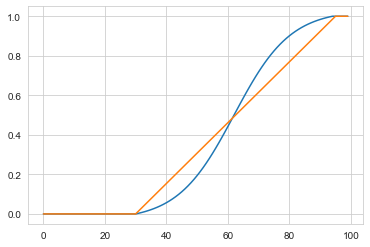

In [20]:
def generate_ramp (n_points = 100,
                         n_start = 20,
                         n_end = 20,
                         zero_one = True, 
                         is_sigmoid = True,
                         slope = 7): 
                       
    # ramp from 0 to 1
    end_amplitude = 1.0
    if(zero_one):
        start_amplitude = 0
    else:
        start_amplitude = -1
    
    # start flat for n_start points
    ramp = [start_amplitude]*n_start
    
    n_points = n_points - n_start - n_end
    
    if is_sigmoid: 
        ramp += list(sigmoid(x_min = 0,
                       x_max = n_points,
                       y_min = start_amplitude,
                       y_max = end_amplitude,
                       n_points = n_points,
                       slope = slope))
    else:
        # linear ramp
        ramp += list(np.arange(0,n_points)/n_points*(end_amplitude-start_amplitude) + start_amplitude)
        
    ramp += [end_amplitude]*n_end

    return ramp
    
sigmoid_ramp = generate_ramp(n_points = 100,
                                       n_start = 30,
                                       n_end = 5,
                                       zero_one = True,
                                       is_sigmoid = True)
linear_ramp = generate_ramp (n_points = 100,
                                       n_start = 30,
                                       n_end = 5,
                                       zero_one = True,
                                       is_sigmoid = False)

_=plt.plot(sigmoid_ramp)
_=plt.plot(linear_ramp)



### Avec morphing

In [53]:
data_df = pd.read_csv('data/data_tours_2.csv', index_col=0)
kernels = compute_kernels(data_df)

In [54]:
def morph(sound_a, sound_b, sr,
          start_ms = 50, 
          end_ms = 50,
          is_sigmoid=True, shift_second=False):
    
    n_a = len(sound_a)
    n_b = len(sound_b)
    if n_a != n_b: 
        print('warning: sounds have different size (%d,%d)'%(n_a,n_b))
    
    n_start = int(sr*start_ms/1000)
    n_end = int(sr*end_ms/1000)                                   
    ramp = generate_ramp(n_points = n_a,
                                   n_start = n_start,
                                   n_end = n_end,
                                   zero_one = True,
                                   is_sigmoid = is_sigmoid)
    
    _=plt.plot(ramp)

    # ramp sound_a down
    sound_a = [sample*weight for (sample, weight) in zip (sound_a,reversed(ramp))]
    
    # ramp sound_b up
    if(shift_second): 
        # shift second sound by n_start, resulting in a longer sound
        sound_b = [0]*n_start + [sample*weight for (sample, weight) in itertools.zip_longest(sound_b,
                                                                                             ramp[n_start:],
                                                                                            fillvalue=1)]
    else:
        sound_b = [sample*weight for (sample, weight) in zip (sound_b,ramp)]
    
    
    return [a+b for (a,b) in itertools.zip_longest(sound_a, sound_b, fillvalue=0)]
    
    
    

In [55]:
def normalize_rms(sound): 
    
    return .7 * sound / np.max(sound)
    

input_file = 'sounds/base_sounds/'+kernels.base_sound.unique()[0]
wave_in,sr =  vmo.readwav(input_file)
norm = normalize_rms(wave_in) 
Audio(data=wave_in, rate=sr)
Audio(data=norm, rate=sr)

  

son de base


smile
eq variation 1/1


unsmile
eq variation 1/1


neutral_smile


smile_neutral


neutral_unsmile


unsmile_neutral


unsmile_smile


smile_unsmile


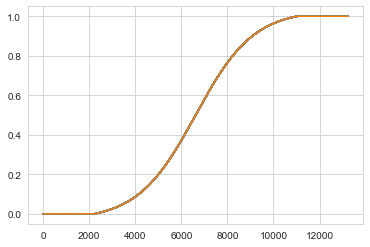

In [58]:
input_file = 'sounds/base_sounds/'+kernels.base_sound.unique()[0]
wave_in,sr =  vmo.readwav(input_file)
wave_in = normalize_rms(wave_in) 

print("son de base")
Audio(data=wave_in, rate=sr)
vmo.writewav('sounds/morphs/neutral.wav', sr, wave_in)

KERNEL_GAIN = 2
flat_MS = 50
IS_SIGMOID = True

print("smile")
# apply smile kernel
kernel = kernels.groupby(['filter_freq']).norm_gain.mean().reset_index()
smile_wave_out, bpf_out = apply_kernel(wave_in, sr, 
                                 kernel.filter_freq, 
                                 kernel.norm_gain, 
                                 KERNEL_GAIN)
smile_wave_out = normalize_rms(smile_wave_out) 
Audio(data=smile_wave_out, rate=sr)
vmo.writewav('sounds/morphs/smile.wav', sr, smile_wave_out)

print("unsmile")
# apply unsmile kernel
unsmile_wave_out, bpf_out = apply_kernel(wave_in, sr, 
                                 kernel.filter_freq, 
                                 -kernel.norm_gain, 
                                 KERNEL_GAIN)
unsmile_wave_out = normalize_rms(unsmile_wave_out) 
Audio(data=unsmile_wave_out, rate=sr)
vmo.writewav('sounds/morphs/unsmile.wav', sr, smile_wave_out)

dynamic_configurations = {'neutral_smile':[wave_in,smile_wave_out],
                          'smile_neutral':[smile_wave_out,wave_in],
                          'neutral_unsmile':[wave_in,unsmile_wave_out],
                          'unsmile_neutral':[unsmile_wave_out,wave_in],
                          'unsmile_smile':[unsmile_wave_out,smile_wave_out],
                          'smile_unsmile':[smile_wave_out,unsmile_wave_out]}

#pitch_factors=[1.0]
pitch_factors= [0.85,0.9,0.95,1.0,1.05,1.1,1.15] # applied on second half of sound

for config in dynamic_configurations:
    
    print(config)
    
    wave_start = dynamic_configurations[config][0]
    #print(wave_start)
    wave_end = dynamic_configurations[config][1]
    #print(wave_end)
        
    for factor in pitch_factors:  
        if factor != 1: 
            morph_wave_out = morph(wave_start, pitch_shift(wave_end, factor),sr,
                       start_ms = flat_MS, end_ms=flat_MS, 
                       is_sigmoid=IS_SIGMOID)
        else:
            morph_wave_out = morph(wave_start, wave_end,sr,
                       start_ms = flat_MS, end_ms=flat_MS, 
                       is_sigmoid=IS_SIGMOID)
        Audio(data=morph_wave_out, rate=sr)
        vmo.writewav('sounds/morphs/%s_%.2f.wav'%(config,factor),
                     sr, morph_wave_out)



Add some pitch_shifting variety

In [39]:
def pitch_shift(wave_in, factor, write_wav=True):     
    wave_out, tts, f0s = vmo.pitch_scaling_snm(wave_in, sr, sps=factor)
    return wave_out

sound_files = glob.glob('sounds/morphs/essai/*.wav')
for sound_file in sound_files: 
    wave_in,sr =  vmo.readwav(sound_file)
    print(sound_file)
    for factor in [0.85,0.9,0.95,1.0,1.05,1.1,1.15]: 
        wave_out = pitch_shift(wave_in, factor)
        vmo.writewav(os.path.splitext(sound_file)[0]+'_%.2f'%factor+'.wav', sr, wave_out)


sounds/morphs/essai\neutral.wav


### Avec time-variable bpf

In [56]:
def weight(bpf, weights):
    # yield scaled versions of final_bpf by successive weights
    for weight in weights:
        # apply weight to filter_gains
        weighted_bpf = bpf.copy()
        weighted_bpf[1::2] = weight * bpf[1::2] 
        yield weighted_bpf
        
def apply_kernel_dynamic(wave_in, sr, 
                         filter_freq, filter_gain, gain,
                         n_points, slope):
        
    # create bpf
    n_channel = len(filter_freq)
    bpf = np.zeros((n_points,2+2*n_channel))
    duration = len(wave_in)/sr
    
    # final_bpf_val is the filter_freq and filter_gain
    final_bpf_val = []
    for f,g in zip(filter_freq,filter_gain): 
        final_bpf_val += f, np.exp(gain*g)
    final_bpf_val = np.array(final_bpf_val)
    
    # iterate over time with scaled versions of final_bpf_val according to n_point sigmoid
    for time_ind, weighted_bpf in enumerate(weight(final_bpf_val,
                                                    sigmoid(0,1,n_points,slope))):
        # construct value as (time, n_channel, weighted_filter)
        time_point = time_ind * duration / (n_points-1) 
        print(time_point)
        bpf_val = [time_point, n_channel] + list(weighted_bpf)      
        bpf[time_ind,:] = bpf_val
       
    # process with cleese
    print(bpf)
    config_file = "random_eq_profile.py"
    wav_out,bpf_out = cleese.process(soundData=wave_in, configFile=config_file, sr=sr, BPF=bpf)
    
    return wav_out, bpf

In [60]:
from IPython.display import Markdown, display, Audio
input_file = 'sounds/'+kernels.base_sound.unique()[0]
wave_in,sr =  vmo.readwav(input_file)

print("son de base")
Audio(data=wave_in, rate=sr)

gain = 1

print("unsmile -> smile")
n_points = 3
slope = 7
kernel_tours = kernels.groupby(['filter_freq']).norm_gain.mean().reset_index()
#kernel_tours = pd.DataFrame.from_dict({'filter_freq':[100,1000,10000],
#                                      'norm_gain':[-1,0,1]})

wave_out, bpf_out = apply_kernel_dynamic(wave_in, sr, 
                                 kernel_tours.filter_freq, 
                                 kernel_tours.norm_gain, 
                                 gain=2, n_points=n_points, slope=slope)

#_=plt.imshow(bpf_out[:,3::2].T, aspect='auto',origin='lower')
#_=plt.colorbar()
#_=plt.plot(bpf_out[0,1]*((sigmoid(0,1,n_points,slope)+1)/2), 'k:',linewidth=2)

Audio(data=wave_out, rate=sr)
# save audio
output_file = os.path.splitext(input_file)[0]+'_smile_tours.wav'
vmo.writewav(output_file, sr, wave_out)
# save config (warning bpf_out are np.exp(gain), so np.log them back to db)
#config_file = os.path.splitext(output_file)[0]+'.txt'
#info = [[x,y] for x,y in zip(bpf_out[0][2::2],np.log(bpf_out[0][3::2]))]
#with open(config_file,'w+',newline='') as file:
#    writer = csv.writer(file);
#    for row in info:
#        _=writer.writerow(row)

print("smile -> unsmile")
wave_out, bpf_out = apply_kernel_dynamic(wave_in, sr, 
                                 kernel_tours.filter_freq, 
                                 kernel_tours.norm_gain, 
                                 gain=-2, n_points=n_points, slope=slope)

Audio(data=wave_out, rate=sr)
# save audio
output_file = os.path.splitext(input_file)[0]+'_smile_tours.wav'
vmo.writewav(output_file, sr, wave_out)
# save config (warning bpf_out are np.exp(gain), so np.log them back to db)
#config_file = os.path.splitext(output_file)[0]+'.txt'
#info = [[x,y] for x,y in zip(bpf_out[0][2::2],np.log(bpf_out[0][3::2]))]
#with open(config_file,'w+',newline='') as file:
#    writer = csv.writer(file);
#    for row in info:
#        _=writer.writerow(row)

son de base


unsmile -> smile
0.0
0.25
0.5
0.75


IndexError: index 3 is out of bounds for axis 0 with size 3

In [46]:
# plus urgent que dynamique

## Analyse internal noise